# LIBRERÍAS

In [1]:
import os
import json
import time
import pandas as pd
from google.oauth2 import service_account
from google.cloud import aiplatform
from google.api_core import exceptions
from vertexai.generative_models import GenerativeModel, GenerationConfig
# Importamos solo lo que está disponible en tu versión de SDK

In [2]:
import re
import io
import csv
import numpy as np
from tqdm import tqdm
import zipfile

from dotenv import load_dotenv

# Data Science & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import display
from wordcloud import WordCloud

# Deep Learning & Generative AI
import torch
import tensorflow as tf
import transformers
import openai
import google.generativeai as genai
from google import genai as google_genai
from google.genai import types

# NLP
import nltk
import spacy

# Data Handling
import openpyxl
from sqlalchemy import create_engine

# APIs & Auth
from googleapiclient.discovery import build

# Other utilities
import requests
from tenacity import retry
from google.cloud import bigquery

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

# Archivos

#### CONECTA+

In [3]:
RUTA_HISTORICO = "../Resultados_Historicos/conecta_summary_20251024.csv"
conecta_2_evaluados = pd.read_csv(RUTA_HISTORICO, sep=',')

conecta_2_evaluados.conversation_id = conecta_2_evaluados.conversation_id.astype(int)

In [4]:
# --- Constantes ---
ARCHIVOS_OBJETIVO = [
    'tbl_conversaciones_conecta2.csv',
    'tbl_encuesta_chat_ia_conecta2.csv',
    'tbl_preguntas_conversacion_conecta2.csv'
]

# --- Funciones utilitarias ---
def limpiar_comas_internas_zip(file_bytes):
    """
    Reemplaza comas internas por punto y coma dentro de campos entre comillas.
    """
    text = file_bytes.decode('utf-8')
    lines = text.splitlines()
    return '\n'.join([
        re.sub(r'"(.*?)"', lambda m: m.group(0).replace(',', ';'), line)
        for line in lines
    ])

def cargar_dataframes_zip(zip_path, archivos_objetivo):
    """
    Carga los DataFrames desde el ZIP especificado.
    """
    dataframes = {}
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for archivo in archivos_objetivo:
            if archivo not in zip_ref.namelist():
                dataframes[archivo] = pd.DataFrame()
                continue
            with zip_ref.open(archivo, "r") as f:
                file_bytes = f.read()
                if archivo in ARCHIVOS_OBJETIVO[:2]:  # Los dos primeros requieren limpieza
                    cleaned_csv = limpiar_comas_internas_zip(file_bytes)
                    df = pd.read_csv(io.StringIO(cleaned_csv), on_bad_lines='skip', sep=";")
                else:
                    df = pd.read_csv(io.BytesIO(file_bytes), on_bad_lines='warn', sep=";")
                df['archivo_origen'] = os.path.basename(zip_path).replace('.zip', '')
                dataframes[archivo] = df
    return dataframes

# --- Selección del ZIP más reciente ---
def obtener_zip_mas_reciente(directorio_zip, patron=r'\d{8}\.zip$'):
    """
    Busca el archivo ZIP más reciente en el directorio especificado.
    """
    files_in_directory = os.listdir(directorio_zip)
    zip_files = [f for f in files_in_directory if re.match(patron, f)]
    if not zip_files:
        raise FileNotFoundError("No se encontraron archivos .zip con fecha en el nombre.")
    latest_zip = max(zip_files)
    return os.path.join(directorio_zip, latest_zip)

# --- Main ---
DIRECTORIO_ZIP = os.path.abspath(os.path.join(os.getcwd(), "../ZIP"))
ZIP_PATH = obtener_zip_mas_reciente(DIRECTORIO_ZIP)

dataframes = cargar_dataframes_zip(ZIP_PATH, ARCHIVOS_OBJETIVO)

# --- Asignación de variables ---
conversaciones_conecta = dataframes['tbl_conversaciones_conecta2.csv']
encuesta_chat_ia_conecta = dataframes['tbl_encuesta_chat_ia_conecta2.csv']
preguntas_conversacion_conecta = dataframes.get('tbl_preguntas_conversacion_conecta2.csv', pd.DataFrame())

# --- Post-procesamiento y reporte ---
print("\n--- Información del DataFrame 'preguntas_conversacion_conecta' ---")
if not preguntas_conversacion_conecta.empty:
    print(f"DataFrame cargado exitosamente con {len(preguntas_conversacion_conecta)} filas.")
    id_cols = [
        'id_tbl_preguntas_conversacion_conecta2',
        'fk_tbl_conversaciones_conecta2'
    ]
    for col in id_cols:
        if col in preguntas_conversacion_conecta.columns:
            preguntas_conversacion_conecta[col] = pd.to_numeric(
                preguntas_conversacion_conecta[col], errors='coerce'
            )
else:
    print("El DataFrame está vacío. Verifica el ZIP y los nombres de archivo.")

preguntas_conversacion_conecta = preguntas_conversacion_conecta.drop_duplicates(
    subset=['id_tbl_preguntas_conversacion_conecta2', 'fk_tbl_conversaciones_conecta2'],
    keep='first'
)


--- Información del DataFrame 'preguntas_conversacion_conecta' ---
DataFrame cargado exitosamente con 37622 filas.


In [5]:
def calcula_incio_semana(num_dia_incio_semana, df, columna_fecha):
  df = df.copy()
  week_start_day = num_dia_incio_semana # Thursday (Monday=0, Sunday=6)

  # Calcula para cada una de las fechas cual es el dia correspondiente a *week_start_day* Ej. si el dia es Jueves y la fecha es 20250101 el jueves fue 20250102
  df['custom_week_start'] = df['fecha_hora_inicio'].dt.normalize() - pd.to_timedelta(df['fecha_hora_inicio'].dt.weekday, unit='D') + pd.to_timedelta(week_start_day, unit='D')

  # Asigna el dia de incio de la "semana" a cada fecha dependiendo si la fecha analizada es anterior o posterior a la *custom_week_start*
  df['custom_week_start'] = np.where(
      df['custom_week_start'] > df['fecha_hora_inicio'],
      df['custom_week_start'] - pd.to_timedelta(7, unit='D'),
      df['custom_week_start']
  )

  return df["custom_week_start"]

In [6]:
# CAMBIOS PSG
conversaciones_conecta['fecha_hora_inicio'] = pd.to_datetime(conversaciones_conecta['fecha_hora_inicio'])
conversaciones_conecta['id_semana'] = calcula_incio_semana(4, conversaciones_conecta, "fecha_hora_inicio")
# Filter dates before 2025-09-04
conversaciones_conecta = conversaciones_conecta[conversaciones_conecta['fecha_hora_inicio'] >= '2025-09-01']
# conversaciones_conecta = conversaciones_conecta[conversaciones_conecta['fecha_hora_inicio'] > '2025-09-04 23:59:59']
# conversaciones_conecta = conversaciones_conecta[conversaciones_conecta['fecha_hora_inicio'] < '2025-09-05']

# Display the filtered DataFrame
print(f"fecha minima en el set de datos {min(conversaciones_conecta["fecha_hora_inicio"])}")
print(f"fecha maxima en el set de datos {max(conversaciones_conecta["fecha_hora_inicio"])}")

fecha minima en el set de datos 2025-09-01 00:21:14
fecha maxima en el set de datos 2025-10-27 09:43:40


In [7]:
# --- Guardar DataFrames en carpeta con nombre del ZIP ---
nombre_zip = os.path.splitext(os.path.basename(ZIP_PATH))[0]
output_dir = os.path.abspath(
    os.path.join(
        os.getcwd(),
        "../Archivos/Conversaciones_Conecta2",
        nombre_zip
    )
)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Carpeta creada: {output_dir}")
    # Guardar cada DataFrame
    conversaciones_conecta.to_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'), index=False)
    encuesta_chat_ia_conecta.to_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'), index=False)
    preguntas_conversacion_conecta.to_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'), index=False)
    print("Archivos guardados correctamente.")
else:
    print(f"La carpeta '{output_dir}' ya existe. No se sobrescriben los archivos.")

# --- Cargar los DataFrames desde la carpeta generada ---
df_conversaciones = pd.read_csv(os.path.join(output_dir, 'tbl_conversaciones_conecta2.csv'))
df_encuesta = pd.read_csv(os.path.join(output_dir, 'tbl_encuesta_chat_ia_conecta2.csv'))
df_preguntas = pd.read_csv(os.path.join(output_dir, 'tbl_preguntas_conversacion_conecta2.csv'))


La carpeta 'c:\Users\gabrieva\Visual_Studio_Code_Files\New Code\[CONECTA+] Actualización_PPT\Archivos\Conversaciones_Conecta2\20251027' ya existe. No se sobrescriben los archivos.


#### CONECTA1

In [8]:
RUTA_CONECTA1 = "../Archivos/Conversaciones_Conecta1/Historico consultas 1.0.csv"
consultas_conecta_1 = pd.read_csv(RUTA_CONECTA1, sep=',')

#### GENESYS

In [9]:
RUTA_GENESYS =  "../Archivos/Genesys/genesys_merged_20251030.csv"
experto_conecta2 = pd.read_csv(RUTA_GENESYS, sep=',')

#### USUARIOS

In [10]:
RUTA_USUARIOS = "../Archivos/Usuarios/regional_concat.csv"
regional_concat = pd.read_csv(RUTA_USUARIOS, sep=',')   

# Transformaciones iniciales

In [11]:
# Pivotear encuesta_chat_ia_conecta para que cada fk_tbl_conversaciones_conecta2 tenga una sola fila
encuesta_pivot = encuesta_chat_ia_conecta.pivot_table(
    index='fk_tbl_conversaciones_conecta2',
    columns='fk_tbl_preguntas_encuesta_chat_ia_conecta2',
    values='calificacion',
    aggfunc='first'
 )

# Renombrar columnas para mayor claridad
encuesta_pivot.columns = [f'calificacion_pregunta_{int(col)}' for col in encuesta_pivot.columns]

# Restablecer el índice para que sea un DataFrame estándar
encuesta_pivot = encuesta_pivot.reset_index()

In [12]:
# Merge actualizado usando encuesta_pivot

preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(preguntas_conversacion_conecta['fk_tbl_conversaciones_conecta2'], errors='coerce')
conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_1 = pd.merge(
    preguntas_conversacion_conecta,
    conversaciones_conecta,
    left_on='fk_tbl_conversaciones_conecta2',
    right_on='id_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('_preg', '_conv')
 )
print(f"Filas tras primer merge: {len(df_merged_1)}")

Filas tras primer merge: 37622


C:\Users\gabrieva\AppData\Local\Temp\ipykernel_4024\3754219274.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversaciones_conecta['id_tbl_conversaciones_conecta2'] = pd.to_numeric(conversaciones_conecta['id_tbl_conversaciones_conecta2'], errors='coerce')


In [13]:
print("Antes del filtro:", len(df_merged_1))

# Filtrar las filas de df_merged_1 donde el correo está en la lista de correos de regional_antioquia
df_merged_1 = df_merged_1[df_merged_1.correo.isin(regional_concat['Correo electrónico'])]

print("Después del filtro:", len(df_merged_1))

df_merged_1 = df_merged_1.merge(regional_concat, left_on='correo', right_on='Correo electrónico', how='left')


Antes del filtro: 37622
Después del filtro: 31099


In [14]:
# Merge con encuesta_pivot
encuesta_pivot['fk_tbl_conversaciones_conecta2'] = pd.to_numeric(encuesta_pivot['fk_tbl_conversaciones_conecta2'], errors='coerce')

df_merged_final = pd.merge(
    df_merged_1,
    encuesta_pivot,
    on='fk_tbl_conversaciones_conecta2',
    how='left'
 )
print(f"Filas tras segundo merge: {len(df_merged_final)}")

df_merged_final.fecha_hora_inicio = pd.to_datetime(df_merged_final.fecha_hora_inicio)
df_merged_final.fecha_hora_fin = pd.to_datetime(df_merged_final.fecha_hora_fin)

Filas tras segundo merge: 32929


In [15]:
df_merged_final['fecha'] = pd.to_datetime(df_merged_final['fecha_hora_inicio']).dt.date
fecha_corte = pd.to_datetime('2025-09-30').date()  # Agrega los paréntesis

df_merged_final = df_merged_final[
    ((df_merged_final['fecha'] <= fecha_corte) & (df_merged_final['REGIONAL'] == 'ANTIOQUIA')) |
    (df_merged_final['fecha'] > fecha_corte)
]

In [16]:
df_merged_final['correo'] = df_merged_final['correo'].str.strip().str.lower()
regional_concat['Correo electrónico'] = regional_concat['Correo electrónico'].str.strip().str.lower()

# Cuenta conversaciones únicas por correo
convs_por_usuario = (
    df_merged_final.groupby('correo')['fk_tbl_conversaciones_conecta2']
    .nunique()
    .reset_index(name='conversaciones_unicas')
)

# Merge con regional_concat (left join), incluyendo todas las columnas de regional_concat
usuarios_conversaciones = regional_concat.merge(
    convs_por_usuario,
    left_on='Correo electrónico',
    right_on='correo',
    how='left'
)

# Llena NaN con 0 (usuarios sin conversaciones)
usuarios_conversaciones['conversaciones_unicas'] = usuarios_conversaciones['conversaciones_unicas'].fillna(0).astype(int)

# Resultado: usuarios_conversaciones tiene todas las columnas de regional_concat + conversaciones_unicas
usuarios_conversaciones.to_csv('conteo_conversaciones_usuario.csv', index=False)

In [17]:
# Set de correos de regional_concat
correos_regional = set(regional_concat['Correo electrónico'])

# Filtra df_merged_final para correos que NO están en regional_concat
df_no_regional = df_merged_final[~df_merged_final['correo'].isin(correos_regional)]

# Cuenta conversaciones únicas de estos usuarios
convs_unicas_no_regional = df_no_regional['fk_tbl_conversaciones_conecta2'].nunique()

print(f"Conversaciones únicas de usuarios NO presentes en regional_concat: {convs_unicas_no_regional}")

Conversaciones únicas de usuarios NO presentes en regional_concat: 0


In [18]:
# Agregar columna flg_experto en genesys
experto_conecta2['flg_experto'] = np.where(experto_conecta2['ESTADO_INTERACCION'].notna(), 1, 0)

# Realizar el merge incluyendo todas las columnas de genesys
df_merged_final = df_merged_final.merge(
    experto_conecta2,
    on='fk_tbl_conversaciones_conecta2',
    how='left',
    suffixes=('', '_genesys')
)

# Asegurar que flg_experto sea 0 si hay nulos
df_merged_final['flg_experto'] = df_merged_final['flg_experto'].fillna(0).astype(int)

# EDA

### CONVERSACIONES NULAS

In [19]:
unidad_tiempo = "fecha_hora_inicio_norm"
unidad_tiempo = "id_semana"

df_cifras_conversaciones = df_merged_final.copy()
df_cifras_conversaciones["fecha_hora_inicio_norm"] = df_cifras_conversaciones["fecha_hora_inicio"].dt.normalize()
df_cifras_conversaciones["respuestas_nulas"] = df_cifras_conversaciones["respuesta"].isna()
df_cifras_conversaciones["respuestas_completas"] = df_cifras_conversaciones["respuesta"].notna()
df_cifras_conversaciones = df_cifras_conversaciones.groupby([unidad_tiempo,"fk_tbl_conversaciones_conecta2"]).agg({"id_tbl_preguntas_conversacion_conecta2":"count",
                                                                                                                              "respuestas_nulas":"sum",
                                                                                                                              "respuestas_completas":"sum"}).reset_index()


df_cifras_conversaciones["conversaciones_sin_rta"] = df_cifras_conversaciones["respuestas_completas"] == 0

gr_cifras_conversaciones = df_cifras_conversaciones.groupby([unidad_tiempo]).agg({"id_tbl_preguntas_conversacion_conecta2":["sum","count"],
                                                                  "respuestas_nulas":["sum"],
                                                                  "respuestas_completas":["sum"],
                                                                  "conversaciones_sin_rta":"sum"})


column_names = ["registros_totales","conversaciones_totales","respuestas_nulas","respuestas_no_nulas","conversaciones_sin_rta"]

gr_cifras_conversaciones = gr_cifras_conversaciones.droplevel(0, axis=1)
gr_cifras_conversaciones.columns = column_names
gr_cifras_conversaciones["conversaciones_con_rta"] = gr_cifras_conversaciones["conversaciones_totales"] - gr_cifras_conversaciones["conversaciones_sin_rta"]
gr_cifras_conversaciones["pct_respuestas_nulas"] = np.round(gr_cifras_conversaciones["respuestas_nulas"] / gr_cifras_conversaciones["registros_totales"] * 100, 1)
gr_cifras_conversaciones["pct_respuestas_no_nulas"] = np.round(gr_cifras_conversaciones["respuestas_no_nulas"] / gr_cifras_conversaciones["registros_totales"] * 100, 1)
gr_cifras_conversaciones["pct_conversaciones_sin_rta"] = np.round(gr_cifras_conversaciones["conversaciones_sin_rta"] / gr_cifras_conversaciones["conversaciones_totales"] * 100, 1)
gr_cifras_conversaciones["pct_conversaciones_con_rta"] = np.round(gr_cifras_conversaciones["conversaciones_con_rta"] / gr_cifras_conversaciones["conversaciones_totales"] * 100, 1)
gr_cifras_conversaciones

orden_salida = ["registros_totales","respuestas_nulas", "pct_respuestas_nulas", "respuestas_no_nulas", "pct_respuestas_no_nulas",
                "conversaciones_totales", "conversaciones_con_rta", "pct_conversaciones_con_rta", "conversaciones_sin_rta", "pct_conversaciones_sin_rta"]
gr_cifras_conversaciones[orden_salida]

,registros_totales,respuestas_nulas,pct_respuestas_nulas,respuestas_no_nulas,pct_respuestas_no_nulas,conversaciones_totales,conversaciones_con_rta,pct_conversaciones_con_rta,conversaciones_sin_rta,pct_conversaciones_sin_rta
id_semana,,,,,,,,,,
2025-08-29,1554,372,23.9,1182,76.1,836,745,89.1,91,10.9
2025-09-05,1342,96,7.2,1246,92.8,748,720,96.3,28,3.7
2025-09-12,672,18,2.7,654,97.3,412,408,99.0,4,1.0
2025-09-19,671,13,1.9,658,98.1,399,391,98.0,8,2.0
2025-09-26,2628,27,1.0,2601,99.0,1498,1489,99.4,9,0.6
2025-10-03,5760,195,3.4,5565,96.6,3396,3307,97.4,89,2.6
2025-10-10,8067,635,7.9,7432,92.1,4618,4559,98.7,59,1.3
2025-10-17,6901,604,8.8,6297,91.2,4010,3952,98.6,58,1.4
2025-10-24,1675,125,7.5,1550,92.5,952,933,98.0,19,2.0


Resumen estadístico general:


,registros_totales,respuestas_nulas,pct_respuestas_nulas,respuestas_no_nulas,pct_respuestas_no_nulas,conversaciones_totales,conversaciones_con_rta,pct_conversaciones_con_rta,conversaciones_sin_rta,pct_conversaciones_sin_rta
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,3252.222222,231.666667,7.144444,3020.555556,92.855556,1874.333333,1833.777778,97.166667,40.555556,2.833333
std,2861.709707,246.852182,6.921183,2662.711875,6.921183,1660.510614,1641.445459,3.162673,34.551089,3.162673
min,671.000000,13.000000,1.000000,654.000000,76.100000,399.000000,391.000000,89.100000,4.000000,0.600000
25%,1342.000000,27.000000,2.700000,1182.000000,92.100000,748.000000,720.000000,97.400000,9.000000,1.300000
50%,1675.000000,125.000000,7.200000,1550.000000,92.800000,952.000000,933.000000,98.000000,28.000000,2.000000
75%,5760.000000,372.000000,7.900000,5565.000000,97.300000,3396.000000,3307.000000,98.700000,59.000000,2.600000
max,8067.000000,635.000000,23.900000,7432.000000,99.000000,4618.000000,4559.000000,99.400000,91.000000,10.900000



Semanas con más respuestas nulas:


,respuestas_nulas
id_semana,
2025-10-10,635
2025-10-17,604
2025-08-29,372



Semanas con mayor % de respuestas nulas:


,pct_respuestas_nulas
id_semana,
2025-08-29,23.9
2025-10-17,8.8
2025-10-10,7.9


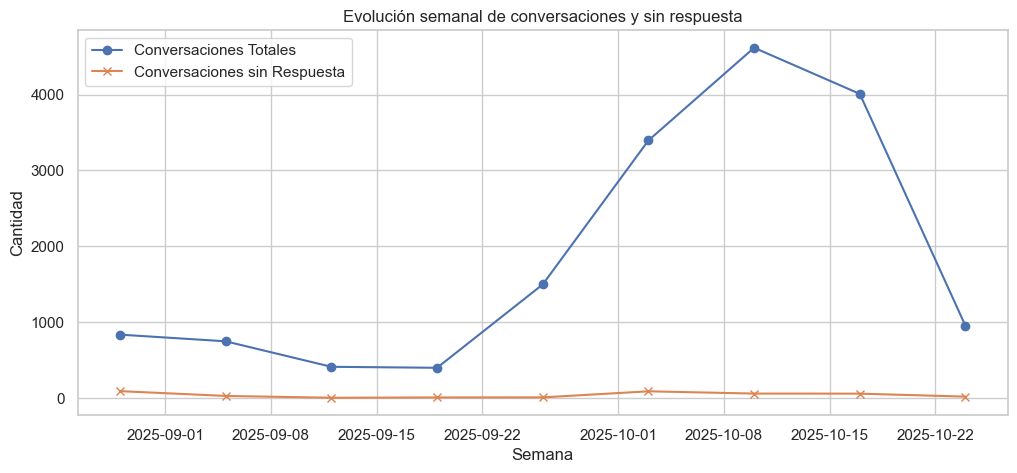

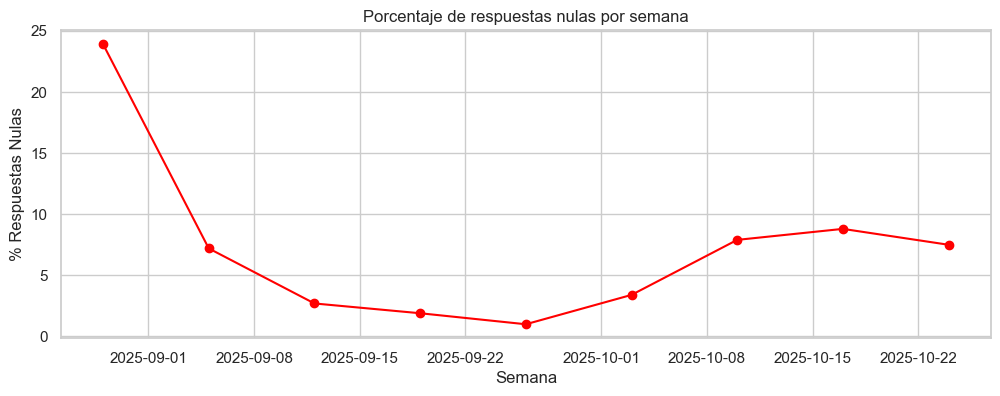


Promedio semanal de conversaciones totales: 1874.3333333333333
Promedio semanal de respuestas nulas: 231.66666666666666
Promedio semanal de % respuestas nulas: 7.144444444444444


In [20]:
import matplotlib.pyplot as plt

# Resumen estadístico general
print("Resumen estadístico general:")
display(gr_cifras_conversaciones[orden_salida].describe())

# Semanas con mayor cantidad de respuestas nulas (problemas)
top_nulas = gr_cifras_conversaciones.sort_values("respuestas_nulas", ascending=False).head(3)
print("\nSemanas con más respuestas nulas:")
display(top_nulas[["respuestas_nulas"]])

# Semanas con mayor porcentaje de respuestas nulas
top_pct_nulas = gr_cifras_conversaciones.sort_values("pct_respuestas_nulas", ascending=False).head(3)
print("\nSemanas con mayor % de respuestas nulas:")
display(top_pct_nulas[["pct_respuestas_nulas"]])

# Evolución semanal de conversaciones y problemas
fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(gr_cifras_conversaciones.index, gr_cifras_conversaciones["conversaciones_totales"], label="Conversaciones Totales", marker='o')
ax1.plot(gr_cifras_conversaciones.index, gr_cifras_conversaciones["conversaciones_sin_rta"], label="Conversaciones sin Respuesta", marker='x')
ax1.set_ylabel("Cantidad")
ax1.set_xlabel("Semana")
ax1.legend()
plt.title("Evolución semanal de conversaciones y sin respuesta")
plt.show()

# Evolución del % de respuestas nulas
plt.figure(figsize=(12,4))
plt.plot(gr_cifras_conversaciones.index, gr_cifras_conversaciones["pct_respuestas_nulas"], marker='o', color='red')
plt.ylabel("% Respuestas Nulas")
plt.xlabel("Semana")
plt.title("Porcentaje de respuestas nulas por semana")
plt.grid(True)
plt.show()

# Resumen de promedios
print("\nPromedio semanal de conversaciones totales:", gr_cifras_conversaciones["conversaciones_totales"].mean())
print("Promedio semanal de respuestas nulas:", gr_cifras_conversaciones["respuestas_nulas"].mean())
print("Promedio semanal de % respuestas nulas:", gr_cifras_conversaciones["pct_respuestas_nulas"].mean())

In [21]:
total_registros = len(df_merged_final)
registros_no_nulos = df_merged_final['respuesta'].notna().sum()
porcentaje_filtrados = (total_registros - registros_no_nulos) / total_registros * 100 if total_registros else 0

print(f"Registros totales antes de filtrar: {total_registros}")
print(f"Registros con respuesta no nula: {registros_no_nulos}")
print(f"Porcentaje de registros filtrados (respuesta nula): {porcentaje_filtrados:.2f}%")

df_merged_final = df_merged_final[~df_merged_final.respuesta.isna()]

# Análisis por conversación: ¿Cuántas conversaciones pierden todos sus registros por filtrado?
convs_totales = df_merged_final['fk_tbl_conversaciones_conecta2'].nunique()
convs_antes = df_merged_1['fk_tbl_conversaciones_conecta2'].nunique() if 'df_merged_1' in locals() else None

if convs_antes is not None:
    print(f"Conversaciones únicas antes de filtrar: {convs_antes}")
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")
    print(f"Porcentaje de conversaciones eliminadas: {((convs_antes - convs_totales) / convs_antes * 100):.2f}%")
else:
    print(f"Conversaciones únicas después de filtrar: {convs_totales}")

Registros totales antes de filtrar: 29270
Registros con respuesta no nula: 27185
Porcentaje de registros filtrados (respuesta nula): 7.12%
Conversaciones únicas antes de filtrar: 18348
Conversaciones únicas después de filtrar: 16504
Porcentaje de conversaciones eliminadas: 10.05%


### RESPUESTAS VÁLIDAS

In [22]:
# Crea la máscara una sola vez
mask = df_merged_final.fk_tbl_conversaciones_conecta2.isin(conecta_2_evaluados.conversation_id.unique())

df_nuevos = df_merged_final[~mask]
df_merged_final = df_merged_final[mask]

In [23]:
import os

In [24]:
try:
    from dotenv import load_dotenv
    load_dotenv()
    print('Variables de entorno cargadas desde .env (si existía).')
except ModuleNotFoundError:
    print('python-dotenv no está instalado; continúa sin cargar archivo .env.')

api_key = os.getenv('GOOGLE_API_KEY')
if not api_key:
    raise RuntimeError('Configura la variable de entorno GEMINI_API_KEY antes de continuar.')

import google.generativeai as genai
from google.api_core import exceptions

genai.configure(api_key=api_key)
MODEL_ID = 'gemini-2.5-flash'
model = genai.GenerativeModel(MODEL_ID)

Variables de entorno cargadas desde .env (si existía).


In [25]:
SYSTEM_PROMPT = """Eres analista de control de calidad del asistente virtual de Banco Davivienda.

Tu tarea es etiquetar la siguiente interacción en EXACTAMENTE una de las siguientes categorías.
Las categorías permitidas son: 'Pregunta valida', 'Sin información', 'Pregunta no valida', o 'Solicitud Paso Experto'.

Reglas de Etiquetado:
1. 'Pregunta valida': la consulta del usuario está relacionada con productos bancarios, procesos de Davivienda, O temas OPERACIONALES relevantes para Davivienda y la respuesta del bot es pertinente y útil. 
2. 'Sin información': La respuesta del bot indica explicitamente que NO tiene información (p. ej., "Lo siento, no encontré..."). Priorizar esta sobre 'Pregunta valida'.
3. 'Pregunta no valida': la consulta es ambigua o NO está relacionada con el contexto bancario o OPERACIONAL DE Davivienda (ej: clima, política), o el enunciado está vacío/incompleto. 
4. 'Solicitud Paso Experto': Petición directa de hablar con un asesor, humano o ejecutivo.

Devuelve JSON con las claves:
- conversation_id (número entero de la conversación).
- category (una de las categorías válidas).
- rationale (breve explicación en español sobre la decisión).

Instrucciones adicionales:
- Prioriza 'Sin información' cuando el bot exprese que no tiene datos, incluso si la pregunta fue válida.
- Etiqueta como 'Solicitud Paso Experto' cualquier petición directa de escalar a un humano aunque la respuesta no lo conceda.
- Usa 'Pregunta no valida' si la pregunta está vacía, contiene caracteres irrelevantes o trata temas ajenos al contexto operativo de Davivienda.
- En los demás casos utiliza 'Pregunta valida' siempre que la respuesta responda a la pregunta.

IMPORTANTE: TU RESPUESTA DEBE SER ÚNICAMENTE EL OBJETO JSON COMPLETO. 
NO AÑADAS NINGÚN BLOQUE DE CÓDIGO (NO USES ```JSON) NI TEXTO EXPLICATIVO."""

VALID_CATEGORIES = {
    'Pregunta valida', 'Sin información', 'Pregunta no valida', 'Solicitud Paso Experto',
}

CATEGORY_ALIASES = {
    'pregunta válida': 'Pregunta valida', 'pregunta valida': 'Pregunta valida', 
    'pregunta no válida': 'Pregunta no valida', 'sin informacion': 'Sin información', 
    'sin información': 'Sin información', 'solicitud paso experto': 'Solicitud Paso Experto',
}


def safe_strip(val):
    if pd.isna(val):
        return ''
    return str(val).strip()

def build_prompt(row):
    conversation_id = int(row.get('fk_tbl_conversaciones_conecta2'))
    pregunta = safe_strip(row.get('pregunta'))
    respuesta = safe_strip(row.get('respuesta'))
    if not pregunta:
        pregunta = '[pregunta vacía]'
    if not respuesta:
        respuesta = '[respuesta vacía]'
    return (
        f"{SYSTEM_PROMPT}\n\n"
        f"ID conversacion: {conversation_id}\n"
        f"Pregunta del usuario: {pregunta}\n"
        f"Respuesta del agente: {respuesta}\n\n"
        'Devuelve solo el JSON requerido.'
    )
    
def parse_gemini_json(text):
    cleaned = text.strip()
    if cleaned.startswith('```'):
        cleaned = cleaned[3:]
        cleaned = cleaned.lstrip()
        if cleaned.lower().startswith('json'):
            cleaned = cleaned[4:].lstrip()
        if cleaned.endswith('```'):
            cleaned = cleaned[:-3]
    if cleaned.lower().startswith('json'):
        cleaned = cleaned[4:].lstrip()
    return json.loads(cleaned)

def classify_with_gemini(row, max_retries=3, base_sleep_seconds=2.0, quota_cooldown_seconds=45):
    prompt = ''.join(build_prompt(row))
    last_error = None
    for attempt in range(max_retries):
        try:
            response = model.generate_content(prompt)
        except exceptions.ResourceExhausted as exc:
            wait_time = max(quota_cooldown_seconds, base_sleep_seconds * (attempt + 1) * 5)
            print(f'Límite de cuota alcanzado; esperando {wait_time:.0f}s antes de reintentar...')
            time.sleep(wait_time)
            last_error = exc
            continue
        except exceptions.GoogleAPICallError as exc:
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error de la API ({exc.__class__.__name__}); reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            last_error = exc
            continue

        candidate_text = ''
        if response.candidates:
            first_candidate = response.candidates[0]
            for part in first_candidate.content.parts:
                if getattr(part, 'text', None):
                    candidate_text += part.text
        candidate_text = candidate_text.strip()
        if not candidate_text:
            last_error = ValueError('Respuesta sin texto interpretable del modelo.')
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Sin texto interpretable; reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
            continue
        try:
            parsed = parse_gemini_json(candidate_text)
            category_raw = (parsed.get('category') or '').strip()
            category = CATEGORY_ALIASES.get(category_raw.lower(), category_raw)
            if category not in VALID_CATEGORIES:
                raise KeyError(f'Categoría no válida recibida: {category_raw}')
            return {
                'conversation_id': int(parsed.get('conversation_id', row.get('fk_tbl_conversaciones_conecta2'))),
                'category': category,
                'rationale': (parsed.get('rationale') or '').strip(),
            }
        except (json.JSONDecodeError, KeyError, AttributeError) as exc:
            last_error = exc
            wait_time = base_sleep_seconds * (attempt + 1)
            print(f'Error interpretando respuesta (intento {attempt + 1}/{max_retries}): {exc}. Reintentando en {wait_time:.1f}s...')
            time.sleep(wait_time)
    raise ValueError(f'No se pudo interpretar la respuesta de Gemini tras {max_retries} intentos. Último error: {last_error}')

In [26]:
# MAX_INTERACTIONS = None  # Cambia a None para clasificar todo el dataset (incrementa el costo).
# subset = df_nuevos if MAX_INTERACTIONS is None else df_nuevos.head(MAX_INTERACTIONS)

# print(f'Clasificando {subset.shape[0]} interacciones...')

# resultados = []
# for index, row in enumerate(subset.to_dict(orient='records'), start=1):
#     resultado = classify_with_gemini(row)
#     resultados.append(resultado)
#     if index % 25 == 0:
#         print(f'{index} interacciones clasificadas...')

# clasificacion = pd.DataFrame(resultados)

In [27]:
from concurrent.futures import ThreadPoolExecutor

# Obtén los IDs ya evaluados en resultados
ids_ya_analizados = conecta_2_evaluados.conversation_id.unique()

# Filtra las filas pendientes en df_nuevos
pendientes = df_nuevos[~df_nuevos['fk_tbl_conversaciones_conecta2'].isin(ids_ya_analizados)]

print(f"Pendientes por evaluar: {len(pendientes)}")

Pendientes por evaluar: 2260


In [28]:
import os
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

# --- Excluir ya procesados si existe archivo parcial ---
if os.path.exists('resultados_paralelo_parcial.csv'):
    resultados_previos = pd.read_csv('resultados_paralelo_parcial.csv')
    ids_ya_procesados = set(resultados_previos['conversation_id'])
    print(f"Ya procesados previamente: {len(ids_ya_procesados)}")
else:
    resultados_previos = pd.DataFrame()
    ids_ya_procesados = set()

# Filtra los pendientes para excluir los ya procesados
pendientes = pendientes[~pendientes['fk_tbl_conversaciones_conecta2'].isin(ids_ya_procesados)]
print(f"Pendientes por analizar tras excluir previos: {len(pendientes)}")

# --- Funciones de procesamiento ---
def split_dataframe(df, n):
    return np.array_split(df, n)

def process_rows(rows, subset_idx=None):
    print(f"Subset {subset_idx} iniciado con {len(rows)} filas")
    resultados = []
    for row in tqdm(rows.to_dict(orient='records'), desc=f"Subset {subset_idx}", position=subset_idx):
        resultados.append(classify_with_gemini(row))
    return resultados

num_workers = 4  # Ajusta según tu CPU y cuota API
subsets = split_dataframe(pendientes, num_workers)

resultados_paralelo = resultados_previos.to_dict(orient='records') if not resultados_previos.empty else []

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    futures = [
        executor.submit(process_rows, subset, idx)
        for idx, subset in enumerate(subsets)
    ]
    for i, future in enumerate(futures, 1):
        subset_result = future.result()
        resultados_paralelo.extend(subset_result)
        pd.DataFrame(resultados_paralelo).to_csv('resultados_paralelo_parcial.csv', index=False)
        print(f"Guardado parcial tras subset {i}: {len(resultados_paralelo)} filas")

# resultados_paralelo contiene todos los resultados nuevos y previos

clasificacion_total_parcial = pd.DataFrame(resultados_paralelo)
clasificacion_total_parcial.to_csv('resultados_clasificacion_total_parcial.csv', index=False)

c:\Users\gabrieva\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Pendientes por analizar tras excluir previos: 2260
Subset 0 iniciado con 565 filas
Subset 1 iniciado con 565 filas
Subset 2 iniciado con 565 filas
Subset 3 iniciado con 565 filas



Subset 0:   0%|          | 0/565 [00:00<?, ?it/s]






Subset 0:   0%|          | 1/565 [00:04<45:08,  4.80s/it]


Subset 0:   0%|          | 2/565 [00:08<38:03,  4.06s/it]


Subset 0:   1%|          | 3/565 [00:12<37:14,  3.98s/it]

Subset 0:   1%|          | 4/565 [00:13<28:13,  3.02s/it]











Subset 0:   1%|          | 5/565 [00:29<1:10:10,  7.52s/it]



Subset 0:   1%|          | 6/565 [00:36<1:08:20,  7.33s/it]

Subset 0:   1%|▏         | 8/565 [00:41<44:21,  4.78s/it]  

Subset 0:   2%|▏         | 9/565 [00:44<37:56,  4.10s/it]





Subset 0:   2%|▏         | 10/565 [00:50<45:03,  4.87s/it]

Subset 0:   2%|▏         | 11/565 [00:54<42:38,  4.62s/it]

Subset 0:   2%|▏         | 12/565 [00:58<39:10,  4.25s/it]


Subset 0:   2%|▏         | 13/565 [01:01<35:11,  3.83s/it]


Subset 0:   2%|▏         | 14/565 [01:03<30:35,  3.33s/it]

Subset 0:   3%|▎         | 15/565 [01:04<25:53,  2.82s/it]








Subset 0:   3%|▎         | 16/565 [01:15<45:59,  5.03s/it]

Subset 0:   3%|▎  

Guardado parcial tras subset 1: 565 filas
Guardado parcial tras subset 2: 1130 filas
Guardado parcial tras subset 3: 1695 filas
Guardado parcial tras subset 4: 2260 filas


In [33]:
df_nuevos_cop = df_nuevos.copy()   
clasificacion_total = pd.DataFrame(resultados_paralelo) 

In [35]:
# El cumcount debe numerar las interacciones dentro de cada conversación
missing_mask = ~df_nuevos_cop['fk_tbl_conversaciones_conecta2'].isin(clasificacion_total['conversation_id'])
if missing_mask.any():
    df_defaults = (
        df_nuevos_cop.loc[missing_mask, ['fk_tbl_conversaciones_conecta2']]
        .rename(columns={'fk_tbl_conversaciones_conecta2': 'conversation_id'})
    )
    df_defaults['category'] = 'Pregunta valida'
    df_defaults['rationale'] = 'Pregunta generica'
    clasificacion_total = pd.concat([clasificacion_total, df_defaults], ignore_index=True)

clasificacion_total['merge_idx'] = clasificacion_total.groupby('conversation_id').cumcount()
df_nuevos_cop['merge_idx'] = df_nuevos_cop.groupby('fk_tbl_conversaciones_conecta2').cumcount()

auditoria = clasificacion_total.merge(
    df_nuevos_cop[['fk_tbl_conversaciones_conecta2', 'fecha_hora_inicio','pregunta', 'respuesta', 'flg_experto', 'motivo_experto', 'REGIONAL','merge_idx', 'calificacion_pregunta_1', 'calificacion_pregunta_2']],
    left_on=['conversation_id', 'merge_idx'],
    right_on=['fk_tbl_conversaciones_conecta2', 'merge_idx'],
    how='left'
)

auditoria['fecha'] = pd.to_datetime(auditoria['fecha_hora_inicio']).dt.date
auditoria["fecha_hora_inicio"] = pd.to_datetime(auditoria["fecha_hora_inicio"])
auditoria["fecha"] = auditoria["fecha_hora_inicio"].dt.date

# cols = ['conversation_id', 'category', 'rationale', 'pregunta', 'respuesta', 'flg_experto']
# auditoria.head()

In [36]:
def clasificacion_no_gestionada(group):
    categorias = group['category'].astype(str).str.strip().str.lower()
    # 1. Preguntas temas no bancarios: al menos una 'pregunta no valida' y ninguna 'sin información'
    if (categorias == 'pregunta no valida').any() and not (categorias == 'sin información').any():
        return 'Preguntas temas no bancarios'
    # 2. Al menos una 'sin información'
    if (categorias == 'sin información').any():
        return 'Sin información'
    # 3. Al menos una 'solicitud paso experto' y ninguna 'sin información'
    if (categorias == 'solicitud paso experto').any() and not (categorias == 'sin información').any():
        return 'Usuario solicitó paso a experto'
    # Si no cumple ninguna, es mezcla de categorías no contemplada
    return 'Otro'

def clasificacion_principal(group):
    categorias_no_gestionada = {'Sin información', 'Solicitud Paso Experto', 'Pregunta no valida'}
    if any(group['category'].isin(categorias_no_gestionada)):
        return 'No Gestionada Conecta'
    else:
        return 'Gestionada Conecta'

def clasificacion_gestionada(group):
    if group['motivo_experto'].isna().all():
        return 'Conecta Retuvo'
    if group['motivo_experto'].notna().any():
        return 'Ofreció PE'
    return 'Otro'


In [37]:
resultados = resultados_paralelo

In [43]:
for cid, group in auditoria.groupby('conversation_id'):
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)
    correo = group['correo'].dropna().iloc[0] if 'correo' in group.columns and group['correo'].notna().any() else None


    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })
    
df_resultados = pd.DataFrame(resultados)

# Filtra correctamente y haz copia para evitar el warning
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()
no_gestionada.loc[:, 'percent_sobre_NGC'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / ngc_convs * 100
no_gestionada.loc[:, 'percent_sobre_total'] = no_gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_NGC=('percent_sobre_NGC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in ngc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_NGC']:.2f}% de NGC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_sum'].sum()}")

# Aplica igual para Gestionada Conecta
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()
gestionada.loc[:, 'percent_sobre_GC'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / gc_convs * 100
gestionada.loc[:, 'percent_sobre_total'] = gestionada.groupby('subgrupo')['conversation_id'].transform('nunique') / df_resultados['conversation_id'].nunique() * 100

gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_sum=('motivo_experto_flag', 'sum'),
    sobre_GC=('percent_sobre_GC', 'first'),
    sobre_total=('percent_sobre_total', 'first')
).reset_index()

for _, row in gc_sub.iterrows():
    print(f"{row['subgrupo']}: {row['conversaciones']} conversaciones ({row['sobre_GC']:.2f}% de GC, {row['sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} | motivo_experto.notna(): {row['motivo_experto_sum']}")

Preguntas temas no bancarios: 92 conversaciones (18.93% de NGC, 6.61% del total) | flg_experto==1: 28.0 | motivo_experto.notna(): 78.0
Sin información: 363 conversaciones (74.69% de NGC, 26.08% del total) | flg_experto==1: 70.0 | motivo_experto.notna(): 176.0
Usuario solicitó paso a experto: 31 conversaciones (6.38% de NGC, 2.23% del total) | flg_experto==1: 38.0 | motivo_experto.notna(): 56.0

Suma total motivo_experto.notna() en No Gestionada Conecta: 310.0
Conecta Retuvo: 728 conversaciones (80.35% de GC, 52.30% del total) | flg_experto==1: 2.0 | motivo_experto.notna(): 0.0
Ofreció PE: 178 conversaciones (19.65% de GC, 12.79% del total) | flg_experto==1: 192.0 | motivo_experto.notna(): 356.0


In [44]:
# Agrupar por conversación y aplicar clasificaciones
resultados = []

# Identifica los conversation_id que solo están en conecta_2_evaluados
ids_evaluados = set(conecta_2_evaluados['conversation_id'])
ids_auditoria = set(auditoria['conversation_id'])
solo_evaluados = ids_evaluados - ids_auditoria

# Primero, agrega los registros originales de conecta_2_evaluados para los que no están en auditoria
for _, row in conecta_2_evaluados[conecta_2_evaluados['conversation_id'].isin(solo_evaluados)].iterrows():
    resultados.append(row.to_dict())

# Luego, concatena y agrupa como antes (esto sobrescribirá los duplicados, pero no los únicos)
# auditoria_full = pd.concat([conecta_2_evaluados, auditoria], ignore_index=True)

for cid, group in auditoria.groupby('conversation_id'):
    # Solo procesa los que no están ya agregados
    if cid in solo_evaluados:
        continue
    grupo_principal = clasificacion_principal(group)
    motivo_experto_flag = int(group['motivo_experto'].notna().any())
    flg_experto_flag = int((group['flg_experto'] == 1).any())

    motivos = group['motivo_experto'].dropna().unique()
    motivo_experto_unicos = motivos[0] if len(motivos) > 0 else None
    regional = group['REGIONAL'].dropna().iloc[0] if group['REGIONAL'].notna().any() else None
    correo = group['correo'].dropna().iloc[0] if 'correo' in group.columns and group['correo'].notna().any() else None
    calif1_mean = pd.to_numeric(group['calificacion_pregunta_1'], errors='coerce').mean()
    calif2_mean = pd.to_numeric(group['calificacion_pregunta_2'], errors='coerce').mean()
    fecha_conv = group['fecha'].min()
    filas_por_conversacion = len(group)

    if grupo_principal == 'No Gestionada Conecta':
        subgrupo = clasificacion_no_gestionada(group)
    else:
        subgrupo = clasificacion_gestionada(group)

    resultados.append({
        'conversation_id': cid,
        'grupo_principal': grupo_principal,
        'subgrupo': subgrupo,
        'flg_experto_flag': flg_experto_flag,
        'motivo_experto_flag': motivo_experto_flag,
        'motivo_experto_unicos': motivo_experto_unicos,
        'REGIONAL': regional,
        'calificacion_pregunta_1_mean': calif1_mean,
        'calificacion_pregunta_2_mean': calif2_mean,
        'fecha': fecha_conv,
        'filas_por_conversacion': filas_por_conversacion,
        'correo': correo
    })

In [45]:
df_resultados = pd.DataFrame(resultados)

In [ ]:
# Guarda el DataFrame en la carpeta de salidas
output_path = r'../Salidas/df_resultados.csv'
df_resultados.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")

Archivo guardado en: ../Salidas/df_resultados.csv


In [36]:
# Muestra solo las filas con calificación válida y agrupa por subgrupo y calificación promedio (redondeada para evitar decimales infinitos)
df_validas = df_resultados[~df_resultados['calificacion_pregunta_2_mean'].isna()].copy()
df_validas['calif2_rounded'] = df_validas['calificacion_pregunta_2_mean'].round(2)
pd.crosstab(df_validas['subgrupo'], df_validas['calif2_rounded'])

calif2_rounded,1.0,2.0,3.0,4.0,5.0
subgrupo,,,,,
Conecta Retuvo,148,29,100,133,545
Ofreció PE,452,58,190,92,196
Preguntas temas no bancarios,8,0,0,2,6
Sin información,31,3,16,7,20
Usuario solicitó paso a experto,18,2,5,3,7


In [42]:
conv_ids = df_resultados[df_resultados['subgrupo'] == 'Conecta Retuvo']['conversation_id'].unique()
 
auditoria_full[auditoria_full['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id']).calificacion_pregunta_2.value_counts()   
# calif_validas = aud_sub['calificacion_pregunta_2'].dropna()

calificacion_pregunta_2
5    30
1    15
4    12
3    11
2     2
Name: count, dtype: int64

In [43]:
auditoria_full

,conversation_id,grupo_principal,subgrupo,flg_experto_flag,motivo_experto_flag,motivo_experto_unicos,REGIONAL,calificacion_pregunta_1_mean,calificacion_pregunta_2_mean,fecha,filas_por_conversacion,correo,category,rationale,merge_idx,fk_tbl_conversaciones_conecta2,fecha_hora_inicio,pregunta,respuesta,flg_experto,motivo_experto,calificacion_pregunta_1,calificacion_pregunta_2
0,2731,Gestionada Conecta,Conecta Retuvo,0.0,0.0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1.0,jainer.blanco@davivienda.com,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2732,Gestionada Conecta,Conecta Retuvo,0.0,0.0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1.0,jainer.blanco@davivienda.com,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,2736,Gestionada Conecta,Conecta Retuvo,0.0,0.0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1.0,luiperez@davivienda.com,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,2737,Gestionada Conecta,Conecta Retuvo,0.0,0.0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1.0,eduard.blandon@davivienda.com,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,2742,Gestionada Conecta,Conecta Retuvo,0.0,0.0,NaN,ANTIOQUIA,NaN,NaN,2025-09-01,1.0,luisa.suarez@davivienda.com,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17366,21818,NaN,NaN,NaN,NaN,NaN,VALLE,NaN,NaN,2025-10-27,NaN,NaN,Pregunta valida,Pregunta generica,1.0,21818.0,2025-10-27 09:41:22,error endoso cdt,"El CDT no se debe endosar, por lo que no exist...",0.0,NaN,NaN,NaN
17367,21821,NaN,NaN,NaN,NaN,NaN,CALL CENTER,NaN,NaN,2025-10-27,NaN,NaN,Pregunta valida,Pregunta generica,0.0,21821.0,2025-10-27 09:42:48,si una cuneta davivienda esta cancelada puede ...,"Lo siento, no encontré información específica ...",0.0,NaN,NaN,NaN
17368,21820,NaN,NaN,NaN,NaN,NaN,VALLE,NaN,NaN,2025-10-27,NaN,NaN,Pregunta valida,Pregunta generica,0.0,21820.0,2025-10-27 09:41:55,sobrante en ATM,"Por favor, reformula tu inquietud: ¿Tu consult...",0.0,NaN,NaN,NaN
17369,21822,NaN,NaN,NaN,NaN,NaN,CENTRO SUR,NaN,NaN,2025-10-27,NaN,NaN,Pregunta valida,Pregunta generica,0.0,21822.0,2025-10-27 09:43:21,depositos a cuentas erradas,"Por favor, reformula tu inquietud: ¿Tu consult...",0.0,NaN,NaN,NaN


In [473]:
df_resultados.calificacion_pregunta_1_mean = df_resultados.calificacion_pregunta_1_mean.astype(float)
df_resultados.calificacion_pregunta_2_mean = df_resultados.calificacion_pregunta_2_mean.astype(float)

df_resultados['motivo_experto_count'] = df_resultados['motivo_experto_flag']  # 1 si motivo_experto existe, 0 si no

total_convs = df_resultados['conversation_id'].nunique()
print("="*60)
print(f"Total conversaciones: {total_convs}")
print("="*60)

# 1. PRIMERA CLASIFICACIÓN
primeros = df_resultados.groupby('grupo_principal').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum')
).reset_index()
primeros['%_sobre_total'] = primeros['conversaciones'] / total_convs * 100

print("PRIMERA CLASIFICACIÓN (Funnel)")
for _, row in primeros.iterrows():
    print(f"{row['grupo_principal']}: {row['conversaciones']} conversaciones ({row['%_sobre_total']:.2f}% del total) | flg_experto==1: {row['flg_experto_sum']} ({row['flg_experto_sum']/total_convs*100:.2f}% del total)")
print("="*60)

# 2. DESGLOSE DE 'No Gestionada Conecta'
no_gestionada = df_resultados[df_resultados['grupo_principal'] == 'No Gestionada Conecta'].copy()
ngc_convs = no_gestionada['conversation_id'].nunique()

print("\nDesglose de No Gestionada Conecta")
ngc_sub = no_gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
ngc_sub['%_sobre_NGC'] = ngc_sub['conversaciones'] / ngc_convs * 100
ngc_sub['%_sobre_total'] = ngc_sub['conversaciones'] / total_convs * 100
ngc_sub['%_flg_experto_total'] = ngc_sub['flg_experto_sum'] / total_convs * 100
ngc_sub['%_motivo_experto_total'] = ngc_sub['motivo_experto_count'] / total_convs * 100

for _, row in ngc_sub.iterrows():
    conv_ids = no_gestionada[no_gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    aud_sub = auditoria_full[auditoria_full['conversation_id'].isin(conv_ids)].drop_duplicates(subset=['conversation_id'])
    calif_validas = aud_sub['calificacion_pregunta_2'].dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None
    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_NGC']:.2f}% de NGC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas} | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else "Sin calificaciones"
    )

print(f"\nSuma total motivo_experto.notna() en No Gestionada Conecta: {ngc_sub['motivo_experto_count'].sum()} ({ngc_sub['motivo_experto_count'].sum()/total_convs*100:.2f}% del total)")

# 3. DESGLOSE DE 'Gestionada Conecta'
gestionada = df_resultados[df_resultados['grupo_principal'] == 'Gestionada Conecta'].copy()
gc_convs = gestionada['conversation_id'].nunique()

print("\nDesglose de Gestionada Conecta")
gc_sub = gestionada.groupby('subgrupo').agg(
    conversaciones=('conversation_id', 'nunique'),
    flg_experto_sum=('flg_experto_flag', 'sum'),
    motivo_experto_count=('motivo_experto_count', 'sum')
).reset_index()
gc_sub['%_sobre_GC'] = gc_sub['conversaciones'] / gc_convs * 100
gc_sub['%_sobre_total'] = gc_sub['conversaciones'] / total_convs * 100
gc_sub['%_flg_experto_total'] = gc_sub['flg_experto_sum'] / total_convs * 100
gc_sub['%_motivo_experto_total'] = gc_sub['motivo_experto_count'] / total_convs * 100

for _, row in gc_sub.iterrows():
    conv_ids = gestionada[gestionada['subgrupo'] == row['subgrupo']]['conversation_id'].unique()
    # Filas de auditoria solo para estas conversaciones
    aud_sub = auditoria_full[auditoria_full['conversation_id'].isin(conv_ids)]
    # Solo filas con calificación válida
    calif_validas = pd.to_numeric(aud_sub['calificacion_pregunta_2'], errors='coerce').dropna()
    total_calificadas = calif_validas.shape[0]
    promedio_calif = calif_validas.mean() if total_calificadas > 0 else None

    print(
        f"{row['subgrupo']}: {row['conversaciones']} conversaciones "
        f"({row['%_sobre_GC']:.2f}% de GC, {row['%_sobre_total']:.2f}% del total) | "
        f"flg_experto==1: {row['flg_experto_sum']} ({row['%_flg_experto_total']:.2f}% del total) | "
        f"motivo_experto.notna(): {row['motivo_experto_count']} ({row['%_motivo_experto_total']:.2f}% del total) | "
        f"Calificadas: {total_calificadas}"
        + (f" | Promedio calificación: {promedio_calif:.2f}" if promedio_calif is not None else " | Sin calificaciones")
    )
    
    
# Calcular el % para flg_experto==1 en Ofreció PE
ofrecio_pe_row = gc_sub[gc_sub['subgrupo'] == 'Ofreció PE']
if not ofrecio_pe_row.empty:
    flg_experto_pe = ofrecio_pe_row['flg_experto_sum'].values[0]
    conversaciones_pe = ofrecio_pe_row['conversaciones'].values[0]
    porcentaje_pe = flg_experto_pe / conversaciones_pe * 100 if conversaciones_pe > 0 else 0
    porcentaje_pe_total = flg_experto_pe / total_convs * 100
    print(f"\nOfreció PE: {flg_experto_pe} conversaciones con flg_experto==1 de {conversaciones_pe} ({porcentaje_pe:.2f}% de PE, {porcentaje_pe_total:.2f}% del total)")

# Detalle de conversaciones clasificadas como 'Otro'
print("\nDetalle de conversaciones clasificadas como 'Otro':")
otros_ids = no_gestionada[no_gestionada['subgrupo'] == 'Otro']['conversation_id'].tolist()
otros_detalle = auditoria[auditoria['conversation_id'].isin(otros_ids)]
print(otros_detalle[['conversation_id', 'category', 'pregunta', 'respuesta', 'flg_experto']])

Total conversaciones: 15121
PRIMERA CLASIFICACIÓN (Funnel)
Gestionada Conecta: 14420 conversaciones (95.36% del total) | flg_experto==1: 1254 (8.29% del total)
No Gestionada Conecta: 701 conversaciones (4.64% del total) | flg_experto==1: 111 (0.73% del total)

Desglose de No Gestionada Conecta
Sin calificaciones
Sin calificaciones
Sin calificaciones

Suma total motivo_experto.notna() en No Gestionada Conecta: 330 (2.18% del total)

Desglose de Gestionada Conecta
Conecta Retuvo: 11578 conversaciones (80.29% de GC, 76.57% del total) | flg_experto==1: 0 (0.00% del total) | motivo_experto.notna(): 0 (0.00% del total) | Calificadas: 1 | Promedio calificación: 5.00
Ofreció PE: 2842 conversaciones (19.71% de GC, 18.80% del total) | flg_experto==1: 1254 (8.29% del total) | motivo_experto.notna(): 2842 (18.80% del total) | Calificadas: 0 | Sin calificaciones

Ofreció PE: 1254 conversaciones con flg_experto==1 de 2842 (44.12% de PE, 8.29% del total)

Detalle de conversaciones clasificadas como '